In [1]:
%matplotlib inline

## Vis - visualizing transforms
This notebook showcases the `nitransforms.vis` module, which implements the functionality to illustrate and view transforms.

### Preamble
Prepare a Python environment and use a temporal directory for the outputs. After that, fetch the actual file from NiBabel documentation.

In [2]:
import os
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib.pyplot as plt

import nibabel as nb
from nitransforms.vis import PlotDenseField

cwd = TemporaryDirectory()
os.chdir(cwd.name)
print(f"This notebook is being executed under <{os.getcwd()}>.")

This notebook is being executed under </private/var/folders/z0/5s6gsggx5qqfxg5gh56g60jm0000gp/T/tmpm4zcwo7r>.


In [3]:
# generalise path here, eg
# transform_file = Path(os.getenv("TEST_DATA_HOME", str(Path.home() / ".nitransforms"))) / "someones_displacement_field.nii.gz"
anat_file = Path(os.getenv("TEST_DATA_HOME", str(Path.home() / "Desktop/nitransforms-tests"))) / "someones_anatomy.nii.gz"
transform_file = Path(os.getenv("TEST_DATA_HOME", str(Path.home() / "Desktop/nitransforms-tests"))) / "someones_displacement_field.nii.gz"
print(transform_file)

/Users/julienmarabotto/Desktop/nitransforms-tests/someones_displacement_field.nii.gz


## Load a displacement field
Info about the transform file here...

<OrthoSlicer3D: /Users/julienmarabotto/Desktop/nitransforms-tests/someones_anatomy.nii.gz (57, 67, 56)>

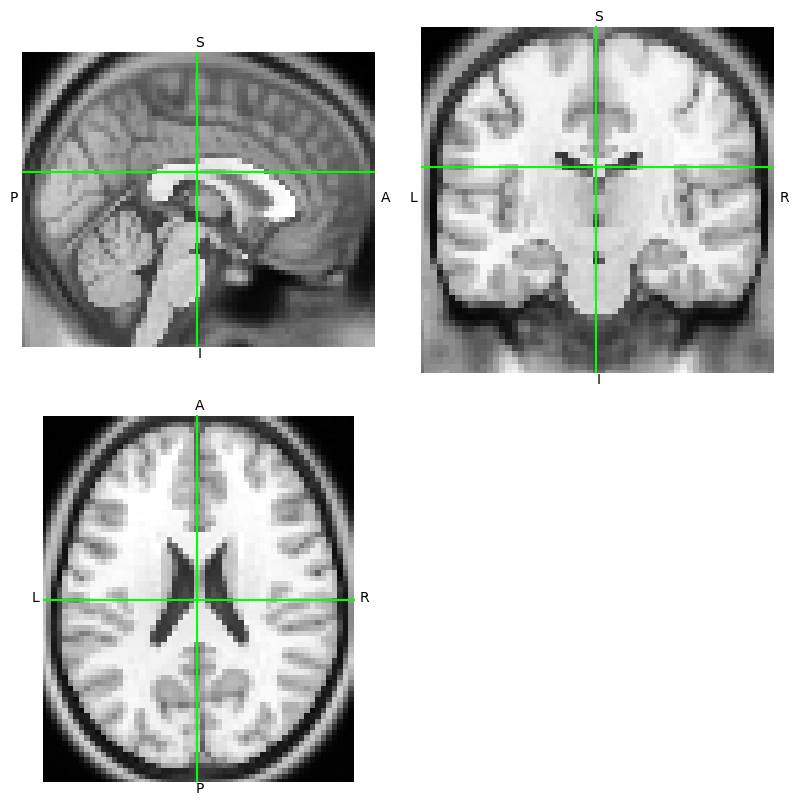

In [4]:
# Load the example
nii = nb.load(anat_file)
hdr = nii.header.copy()
aff = nii.affine.copy()
data = np.asanyarray(nii.dataobj)
nii.orthoview()

## Displacement fields
About displacement fields here...

Using `PlotDenseField()` from the `nitransforms.vis` module, we can prepare the ground for the illustration of a dense field transform object. `PlotDenseField()` takes three aruments: the transform file, an indication regarding the nature of the transform (default: deltas field) and a reference (default: None). We must also define slices to select which axial, coronal and sagittal planes we wish to visualise.

Looking at the corresponding field for the example nifti file showcased above:

In [5]:
xslice, yslice, zslice = 30, 30, 30

pdf = PlotDenseField(
    transform=transform_file,
    is_deltas=True,
)
print(pdf, pdf._xfm._field.shape)

<nitransforms.vis.PlotDenseField object at 0x11d966f00> (57, 67, 56, 3)


## Plot distortion
To sbegin, we can use the `DenseFieldTransform().plot_distortion` module to visualise the deformed grid and superimpose it onto the density map of the deformation. 

/Users/julienmarabotto/workspace/nitransforms/nitransforms/vis.py:220: RuntimeWarning: invalid value encountered in divide
  c = c / c.max()


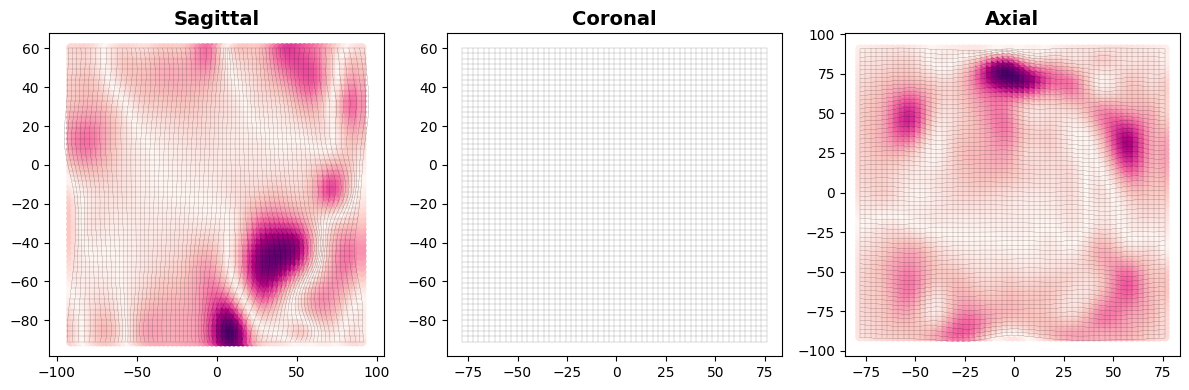

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
pdf.plot_distortion(
    axes=axes,
    xslice=xslice,
    yslice=yslice,
    zslice=zslice,
)

In this example, we notice that the coronal slice contains no deformations, hinting that the transform is only dependent on the y-dimension, ie that the deltas field only contains non-zero $V_y$ vector-components. The distortions of both Axial and Sagittal planes confirm this, with the grid being unaffected in $x$ and $z$ (ie $V_{x, i} = V_{y, i} = 0$ for all $i$). 

## Quiver deformation scalar map
To verify this, we can plot the field using `DenseFieldTransform().plot_quiverdsm` and view the transformation as a quiver plot. Here, the colors represent the dominant vector components of the transform field accroding to the standard convention for deformation scalar maps: red ($V_x$-dominant), green ($V_y$-dominant) and blue ($V_z$-dominant).

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


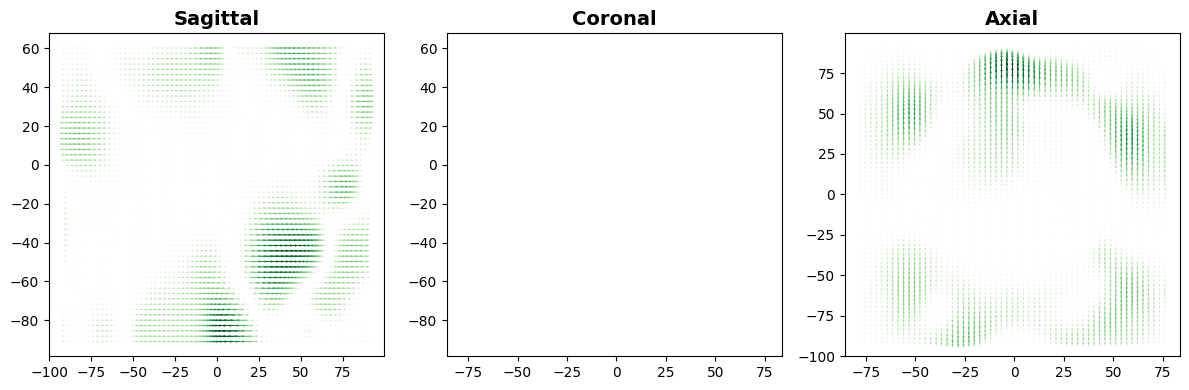

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
pdf.plot_quiverdsm(
    axes=axes,
    xslice=xslice,
    yslice=yslice,
    zslice=zslice,
)

As expected, the field is restrained to a single spatial dimension ($V_y$) and is most intense in the areas where gridlines are subject to the most distortions. The magnitude of the field at any point is represented by the length of the correspodning arrow, while the colour represence the dominance of the dimensional component. In this example, given that the transformation is confined to one dimension, these measures are equivalent and, indeed, the color intensity is also a proxy for arrow length. As we will see further down, this is not always true when dealing with non-zero, three-dimensional transformation fields.

## Transformation fields in three dimensions
Let's now look at a more complicated dense field transform, this time containing deformations in all three spatial dimensions. 

In [8]:
transform_3d = Path(os.getenv("TEST_DATA_HOME", str(Path.home() / "workspace/nitransforms/nitransforms/tests/data"))) / "ds-005_sub-01_from-OASIS_to-T1_warp_fsl.nii.gz"

In [9]:
xslice, yslice, zslice = 50, 50, 50

pdf_3d = PlotDenseField(
    transform=transform_3d,
    is_deltas=True,
)
print(pdf_3d, pdf_3d._xfm._field.shape)

<nitransforms.vis.PlotDenseField object at 0x126318b40> (108, 146, 128, 3)


We can start by taking a look at the deformation grid.

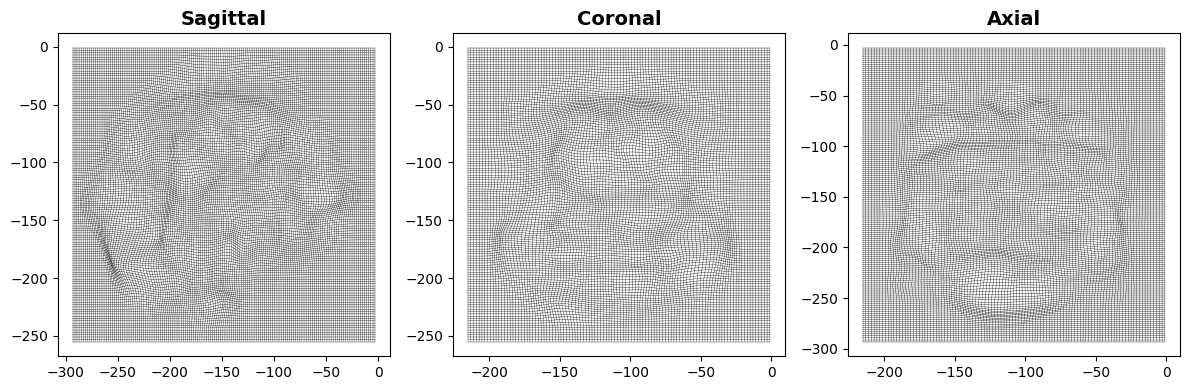

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
pdf_3d.plot_distortion(
    axes=axes,
    xslice=xslice,
    yslice=yslice,
    zslice=zslice,
    lw=0.25,
    show_brain=False,
)
plt.show()

The three-dimensional deformations can easily be identified through the distortion of the coordinate grid alone. 

As in 1D, we again want to see how the field looks as a quiver plot.

# Quiver and deformation scalar map
Once again, it is straightfowrad to highlight the dominance of each dimension using `PlotDensefield().plot_quiverdsm`... 

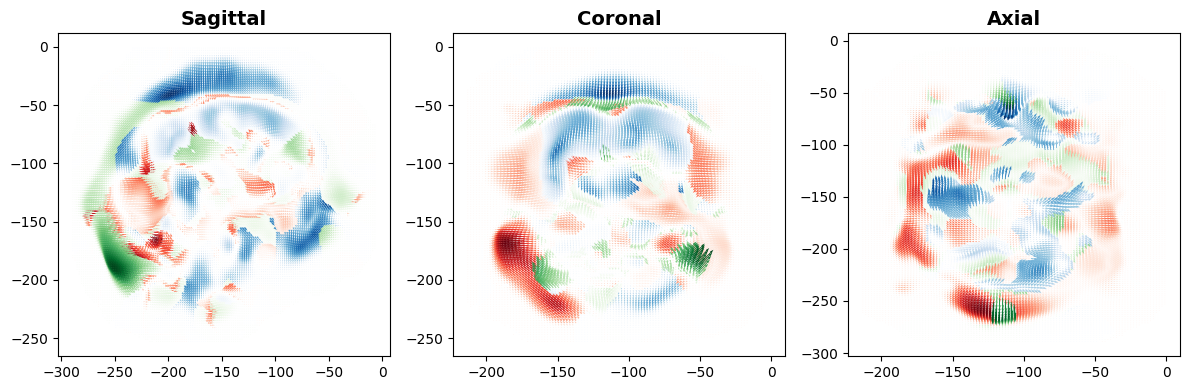

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
pdf_3d.plot_quiverdsm(
    axes = axes,
    xslice=xslice,
    yslice=yslice,
    zslice=zslice
)
plt.show()

... which now allows us to identify which regions of the transform field have dominant $x$- (red), $y$- (green) or $z$- (blue) vector components.

The color of each arrow therefore highlights which of the three directional components ($V_x$, $V_y$ or $V_z$) is dominant. The intensity of the color maps the strength of the dominant dimension (eg pale red -> dark red represents low $V_x$ -> high $V_x$, and similarly for $y$- and $z$- components with green and blue, respectively). The magnitude of the vector is still represented by the arrow length. 

For example, a vector $\textbf{V} = (0.1, 0.2, 0.5)$ with magnitude $V \approx 0.5$ has a slightly dominant $V_z$ and a relatively low magnitude, so will appear pale blue with a relatively short arrow. On the other hand, although a different vector $\textbf{V} = (7.2, 7.4, 7.8)$ with $V \approx 13$ still has a very small $z$-dominace, the $V_z$ component is significantly larger causing the arrow to take a dark blue color. Independently of the color, this vector will be long due to it's large magnitude.

# Jacobians
Now that our field has components in more than one dimension, we can also use `PlotDenseField().plot_jacobian` to map out the jacobians of the vector field and highlight regions in which the transformation represents an expansion (red, $J>0$) or a contraction (blue, $J<0$) of the brain.

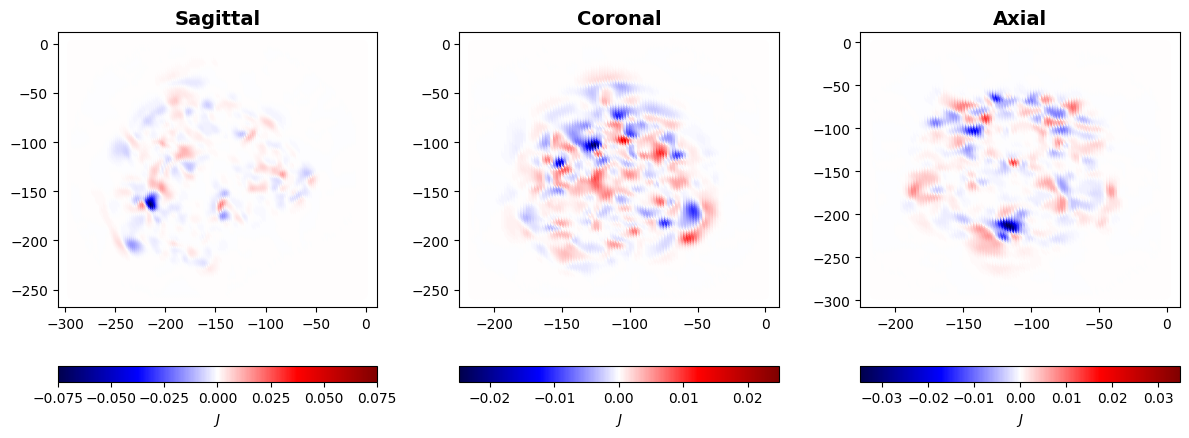

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4.5), tight_layout=True)
pdf_3d.plot_jacobian(
    axes=axes,
    xslice=xslice,
    yslice=yslice,
    zslice=zslice,
)

## Transform overview
Now that we have unpacked the dense field transform, we can now bring this all together with `PlotDenseField().show_transform`. This creates a 3x3 grid of plots to provide the user with an overview of the transformation field contained in the nifti file.

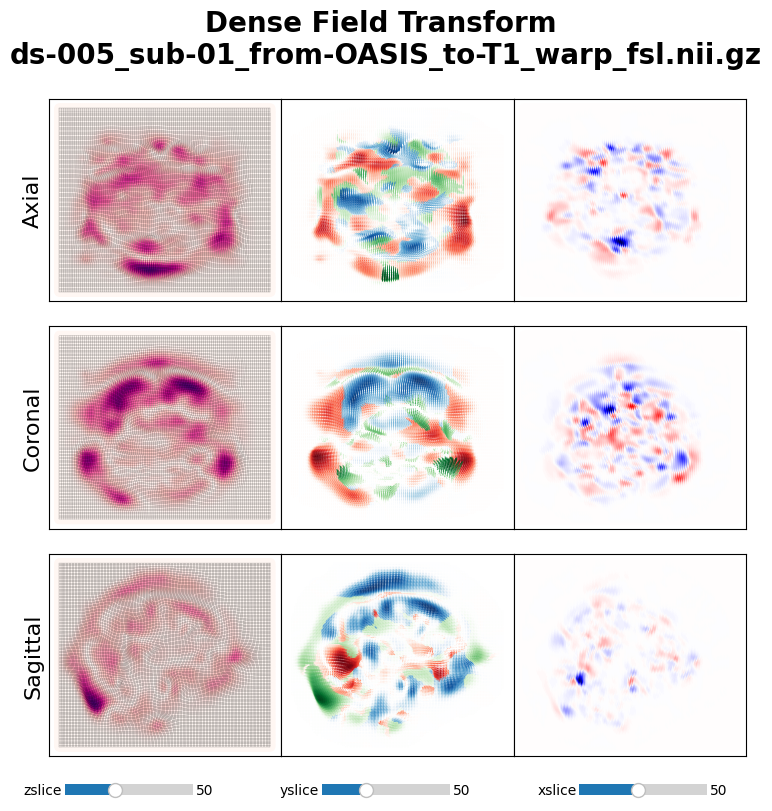

In [46]:
pdf_3d.show_transform(
    xslice=xslice,
    yslice=yslice,
    zslice=zslice,
)
plt.show()

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
pdf_3d.plot_coeffs(
    axes=axes,
    xslice=xslice,
    yslice=yslice,
    zslice=zslice,
)
plt.show()

TypeError: PlotDenseField.plot_coeffs() missing 1 required positional argument: 'axes'